In [163]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=[20,30]
df1=pd.read_csv('Bengaluru_House_Data.csv')
df1.head()
df1.shape

df2=df1.drop(['area_type','society','balcony','availability'],axis='columns')

df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [164]:
df2.isnull().sum()
df3= df2.dropna()
df3.isnull().sum()


df3['size'].unique()
df3.loc[:, 'BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.head()

df3['BHK'].unique()

df3[df3.BHK>20]
df3.total_sqft.unique()

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

df3[~df3['total_sqft'].apply(is_float)]

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

df4 = df3.copy()
df4.loc[:, 'total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head()

df4.loc[30]

C:\Users\User\AppData\Local\Temp\ipykernel_4864\1578409682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, 'BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
BHK                   4
Name: 30, dtype: object

In [165]:
df5=df4.copy()

df5['price_per_sqft']=df5['price']*100000/df5['total_sqft']
df5.head()

len(df5.location.unique())

df5.location = df5.location.apply(lambda x: x.strip())
location_stats= df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

len(location_stats[location_stats<=10])

location_stats_less_than_10=location_stats[location_stats<10]
location_stats_less_than_10

len(df5.location.unique())

df5.location=df5.location.apply(lambda x:'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

df5[df5.total_sqft/df5.BHK<300].head()

df5.shape
df6=df5[~(df5.total_sqft/df5.BHK<300)]
df6.shape


df6.price_per_sqft.describe()

count     12456.0
unique     7340.0
top        5000.0
freq        146.0
Name: price_per_sqft, dtype: float64

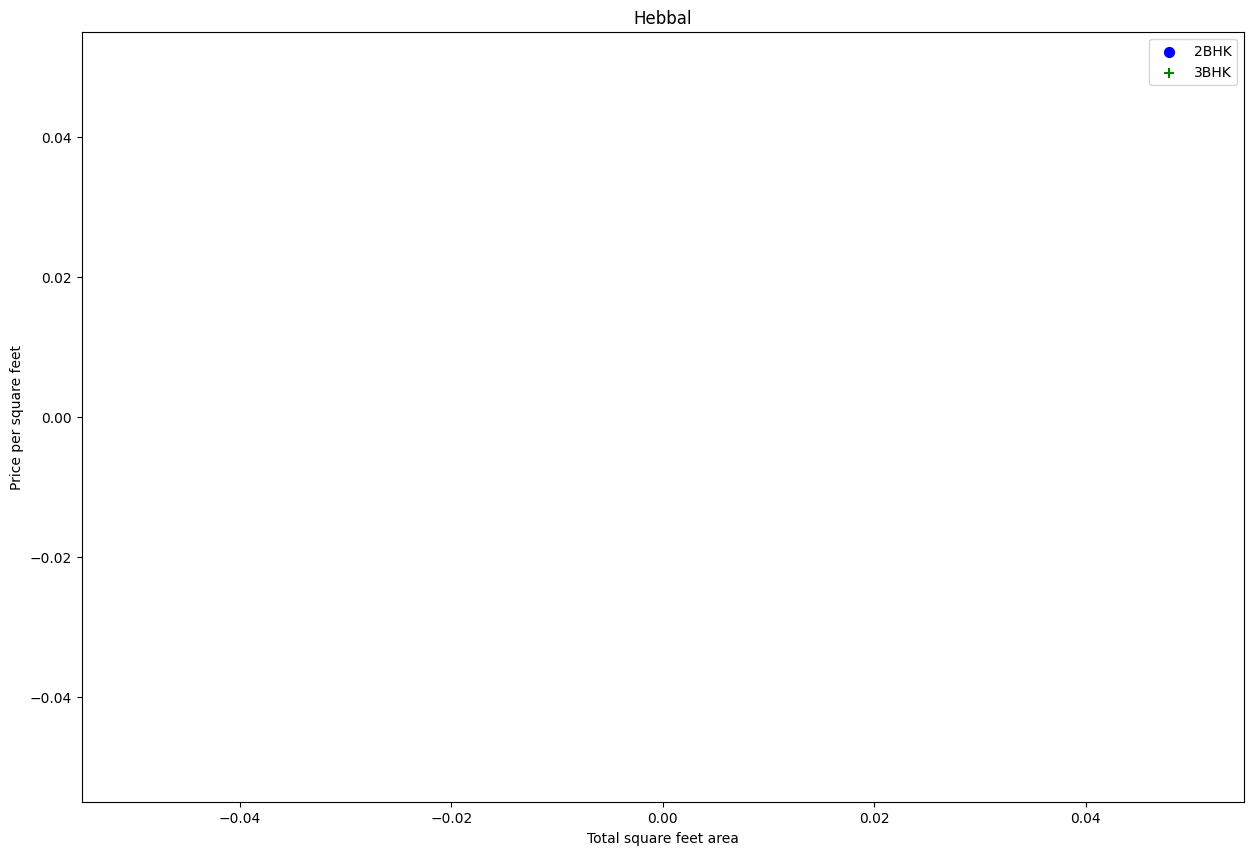

In [166]:
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        sd = np.std(subdf.price_per_sqft)

        reduced_df=subdf[(subdf.price_per_sqft>(m-sd))&(subdf.price_per_sqft<=(m+sd))]
        df_out=pd.concat([df_out, reduced_df], ignore_index=True)
        return df_out

df7 =remove_pps_outliers(df6)
df7.shape


def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.BHK == 2)]
    bhk3 = df[(df.location == location) & (df.BHK == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3BHK', s=50)
    plt.xlabel('Total square feet area')
    plt.ylabel('Price per square feet')
    plt.title(location)
    plt.legend()

plot_scatter_chart(df7, 'Hebbal')


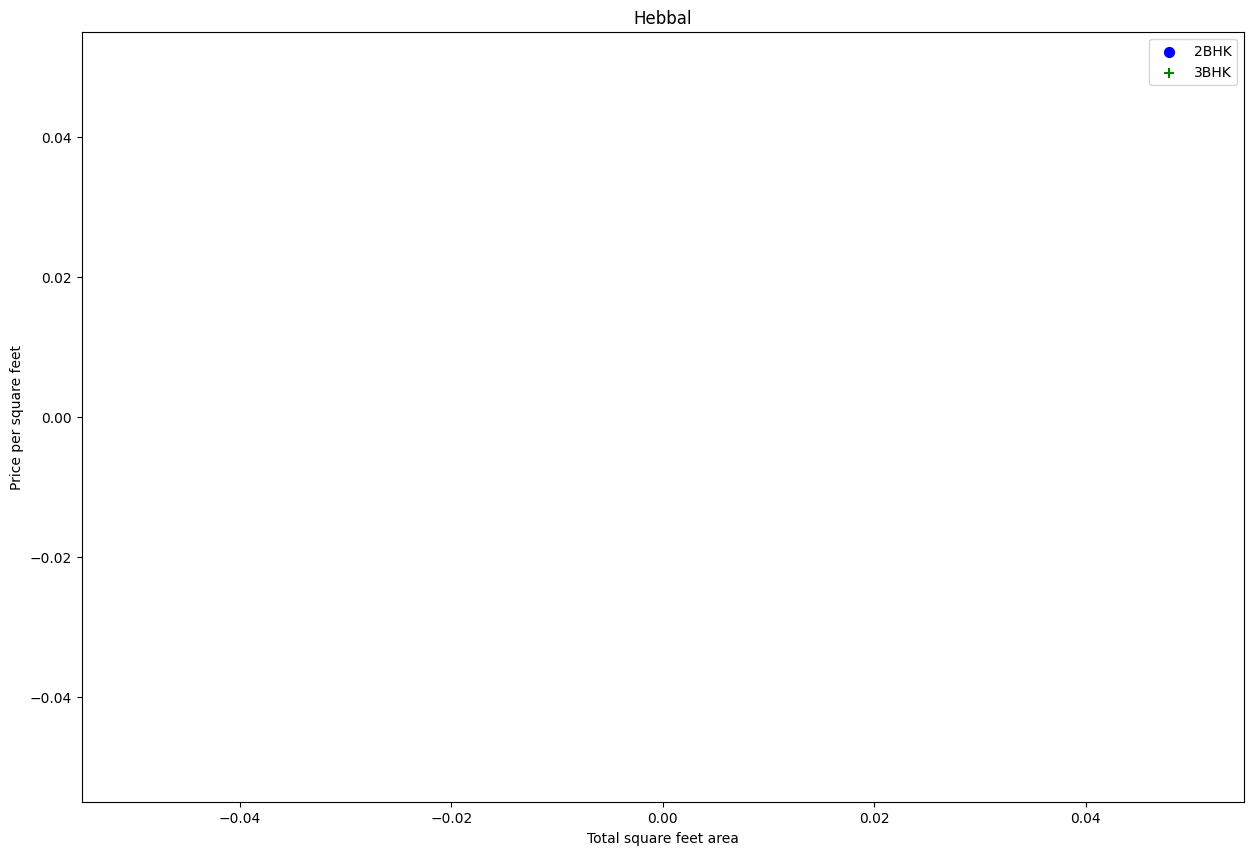

In [167]:
def remove_bhk_outliers(df):
    exclude_indices=np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats={}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk]={
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats=bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

df8 = remove_bhk_outliers(df7)
df8.shape

plot_scatter_chart(df8, 'Hebbal')

(7, 5)

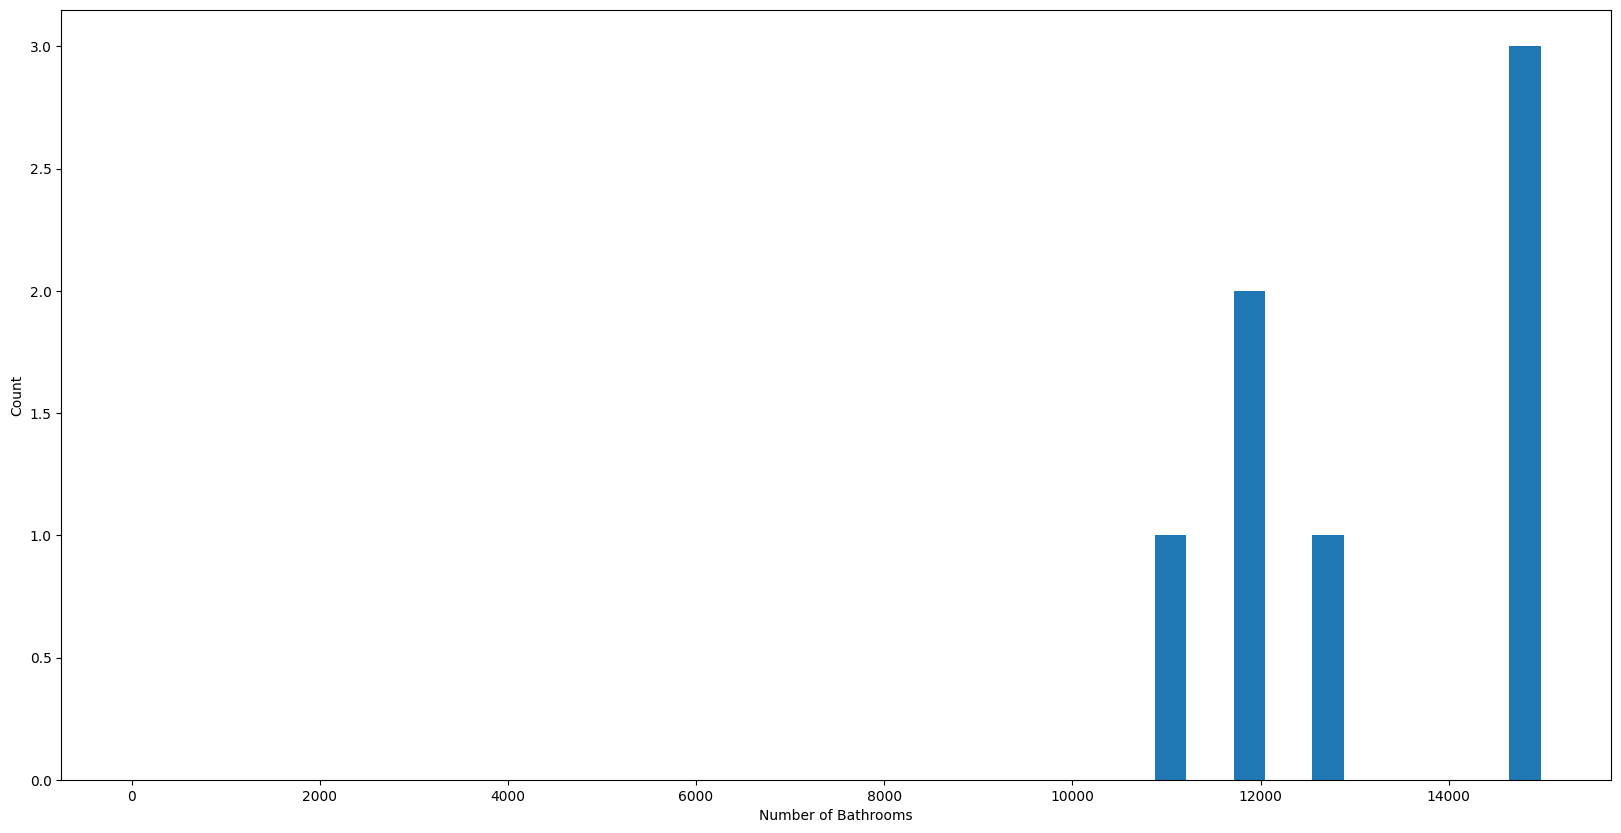

In [168]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (20, 10)
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')

df8.bath.unique()
df8[df8.bath > 10]

plt.hist(df8.bath, rwidth=0.8)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')

df8[df8.bath > df8.BHK + 2]

df9 = df8[df8.bath < df8.BHK + 2]
df9.shape

df10 = df9.drop(['size', 'price_per_sqft'], axis='columns')
df10.head()

dummies = pd.get_dummies(df10.location)
dummies.head()
#df11 = pd.concat([df10, dummies.drop('others', axis='columns')], axis='columns')
if 'others' in dummies.columns:
    df11 = pd.concat([df10, dummies.drop('others', axis='columns')], axis='columns')
else:
    df11 = pd.concat([df10, dummies], axis='columns')

df11.head()
df11.head()

df12 = df11.drop('location', axis='columns')
df12.head()

df12.shape

In [169]:
X = df12.drop('price', axis='columns')
y = df12['price'] 
X.head

from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=10)

from sklearn.linear_model import LinearRegression
lr_clf=LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'copy_X': [True, False],
                'n_jobs': [None],
                'positive': [False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['absolute_error', 'poisson', 'squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(X, y)



,model,best_score,best_params
0,linear_regression,0.923018,"{'copy_X': True, 'fit_intercept': False, 'n_jo..."
1,lasso,0.976480,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.656748,"{'criterion': 'poisson', 'splitter': 'best'}"


In [170]:
def predict_price(location, sqft, bath, bhk):
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    loc_index = np.where(X.columns == location)[0]
    
    if len(loc_index) > 0:
        x[loc_index[0]] = 1
        return lr_clf.predict([x])[0]
    else:
        return "Location not found in columns"
print("Columns in X:", X.columns)
print('Expected house price: ',predict_price('1st Block Jayanagar', 1500, 3, 2),'Lakhs')


import pickle
with open('bangalore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

import json
columns={
    'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))

Columns in X: Index(['total_sqft', 'bath', 'BHK', '1st Block Jayanagar'], dtype='object')
Expected house price:  174.68129353233874 Lakhs


c:\Python38\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
